<h1 align="center"><b> Review Results </b></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from config import path
from tournament_simulations.data_structures import Matches, PointsPerMatch
from turning_point.metric_stats import ExpandingMetricStats
from turning_point.normal_coefficient import TurningPoint
from turning_point.permutation_coefficient import PermutationTurningPoint


In [2]:
import data_analysis.plots.utils.customization
import data_analysis.plots.comparison_scatter as comp_scatter
from data_analysis.plots.utils.plot_functions import flatten_axes

In [3]:
import logging
from logs import turning_logger

turning_logger.setLevel(logging.INFO)

In [4]:
SPORTS = ("basketball", "handball", "soccer", "volleyball")

REVIEW_PATH = path.DATA_PATH / "review/"
REVIEW_PATH.mkdir(parents=True, exist_ok=True)

<h2> <b>Dataset</b> </h2>

In [5]:
from data_analysis.read_datasets import read_as_dicts

In [6]:
KEYS_TO_READ = [
    "matches",
    "stats",
    "optimal_stats",
    "tp",
    "permuted_tp",
    "optimal_tp",
    "diff_points_tp",
]

key_to_sport_to_data = read_as_dicts(SPORTS, KEYS_TO_READ)

In [8]:
import warnings
from turning_point.permutation_coefficient import TurningPointComparison

PERCENTILES = [2.5, 25, 50, 75, 97.5]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    key_to_sport_to_data["comparison_tp"] = {
        sport: TurningPointComparison(
            key_to_sport_to_data["tp"][sport], 
            key_to_sport_to_data["permuted_tp"][sport],
            key_to_sport_to_data["optimal_tp"][sport],
        ).comparison(PERCENTILES)
        for sport in SPORTS
    }

In [9]:
import random
from synthetic_tournaments import Scheduler
from synthetic_tournaments.permutation import scheduling as sch
from tournament_simulations.permutations import MatchesPermutations

def permute_matches(matches: Matches, num_permutations: int = 100) -> Matches:
    turning_logger.info("Permuting")
    scheduler_factory = Scheduler(matches, sch.circle_method.create_double_rr)
    scheduler = scheduler_factory.get_current_year_scheduler()

    permutations_creator = MatchesPermutations(matches, scheduler)
    return permutations_creator.create_n_permutations(num_permutations)

PARAMETERS = {"num_iteration_simulation": (10, 100), "quantile": 0.95}

def turning_point_from_matches(matches: Matches, parameters: dict = PARAMETERS):
    turning_logger.info("Calculating metric stats")
    expanding_var = ExpandingMetricStats.from_matches(matches, **parameters)
    turning_logger.info("Calculating turning point")
    return TurningPoint.from_expanding_var_stats(expanding_var)

<h2> <b>Upsets: Oracle</b> </h2>

In [10]:
UPSETS_PATH = REVIEW_PATH / "upsets/"
UPSETS_PATH.mkdir(parents=True, exist_ok=True)

In [11]:
def get_team_ranks(matches: Matches):
    """
    If teams ended with the same amount of points, there have the same rank.
    """
    def _map_points_to_ranking(rankings: pd.DataFrame) -> dict[str, int]:
        unique_points = sorted(rankings["points"].unique(), reverse=True)
        return {point: i for i, point in enumerate(unique_points)}

    rankings = PointsPerMatch.from_home_away_winner(matches.home_away_winner()).rankings
    return (
        rankings
        .groupby("id", group_keys=False)
        .apply(lambda df: df["points"].map(_map_points_to_ranking(df)))
    )

def get_upset_proportion(matches: Matches) -> pd.Series:
    """
    Edge case: 
        Both teams ended up with the same amount of points:
            They have the same rank, so it is not an upset regardless of who wins.
    """
    id_to_ranks = get_team_ranks(matches)

    def _map_team_to_ranking(names: pd.Series):
        id_ = names.name
        return names.map(id_to_ranks.loc[id_])

    home_rank = matches.df["home"].groupby("id").apply(_map_team_to_ranking).astype(int)
    away_rank = matches.df["away"].groupby("id").apply(_map_team_to_ranking).astype(int)

    expected_winner = (home_rank < away_rank).map({True: "h", False: "a"})
    return (expected_winner != matches.df["winner"]).groupby("id").mean()

In [12]:
PLOT_COLUMNS = {
    ("%turning point", "mean"): r"Expected $\hat\tau_\%$", 
    "%upsets": "%Upsets (oracle)"
}

sport_to_upset_df = {
    sport: pd.concat(
        [
            key_to_sport_to_data["comparison_tp"][sport],
            get_upset_proportion(key_to_sport_to_data["matches"][sport]).rename("%upsets")
        ], axis="columns"
    )
    for sport in SPORTS
}

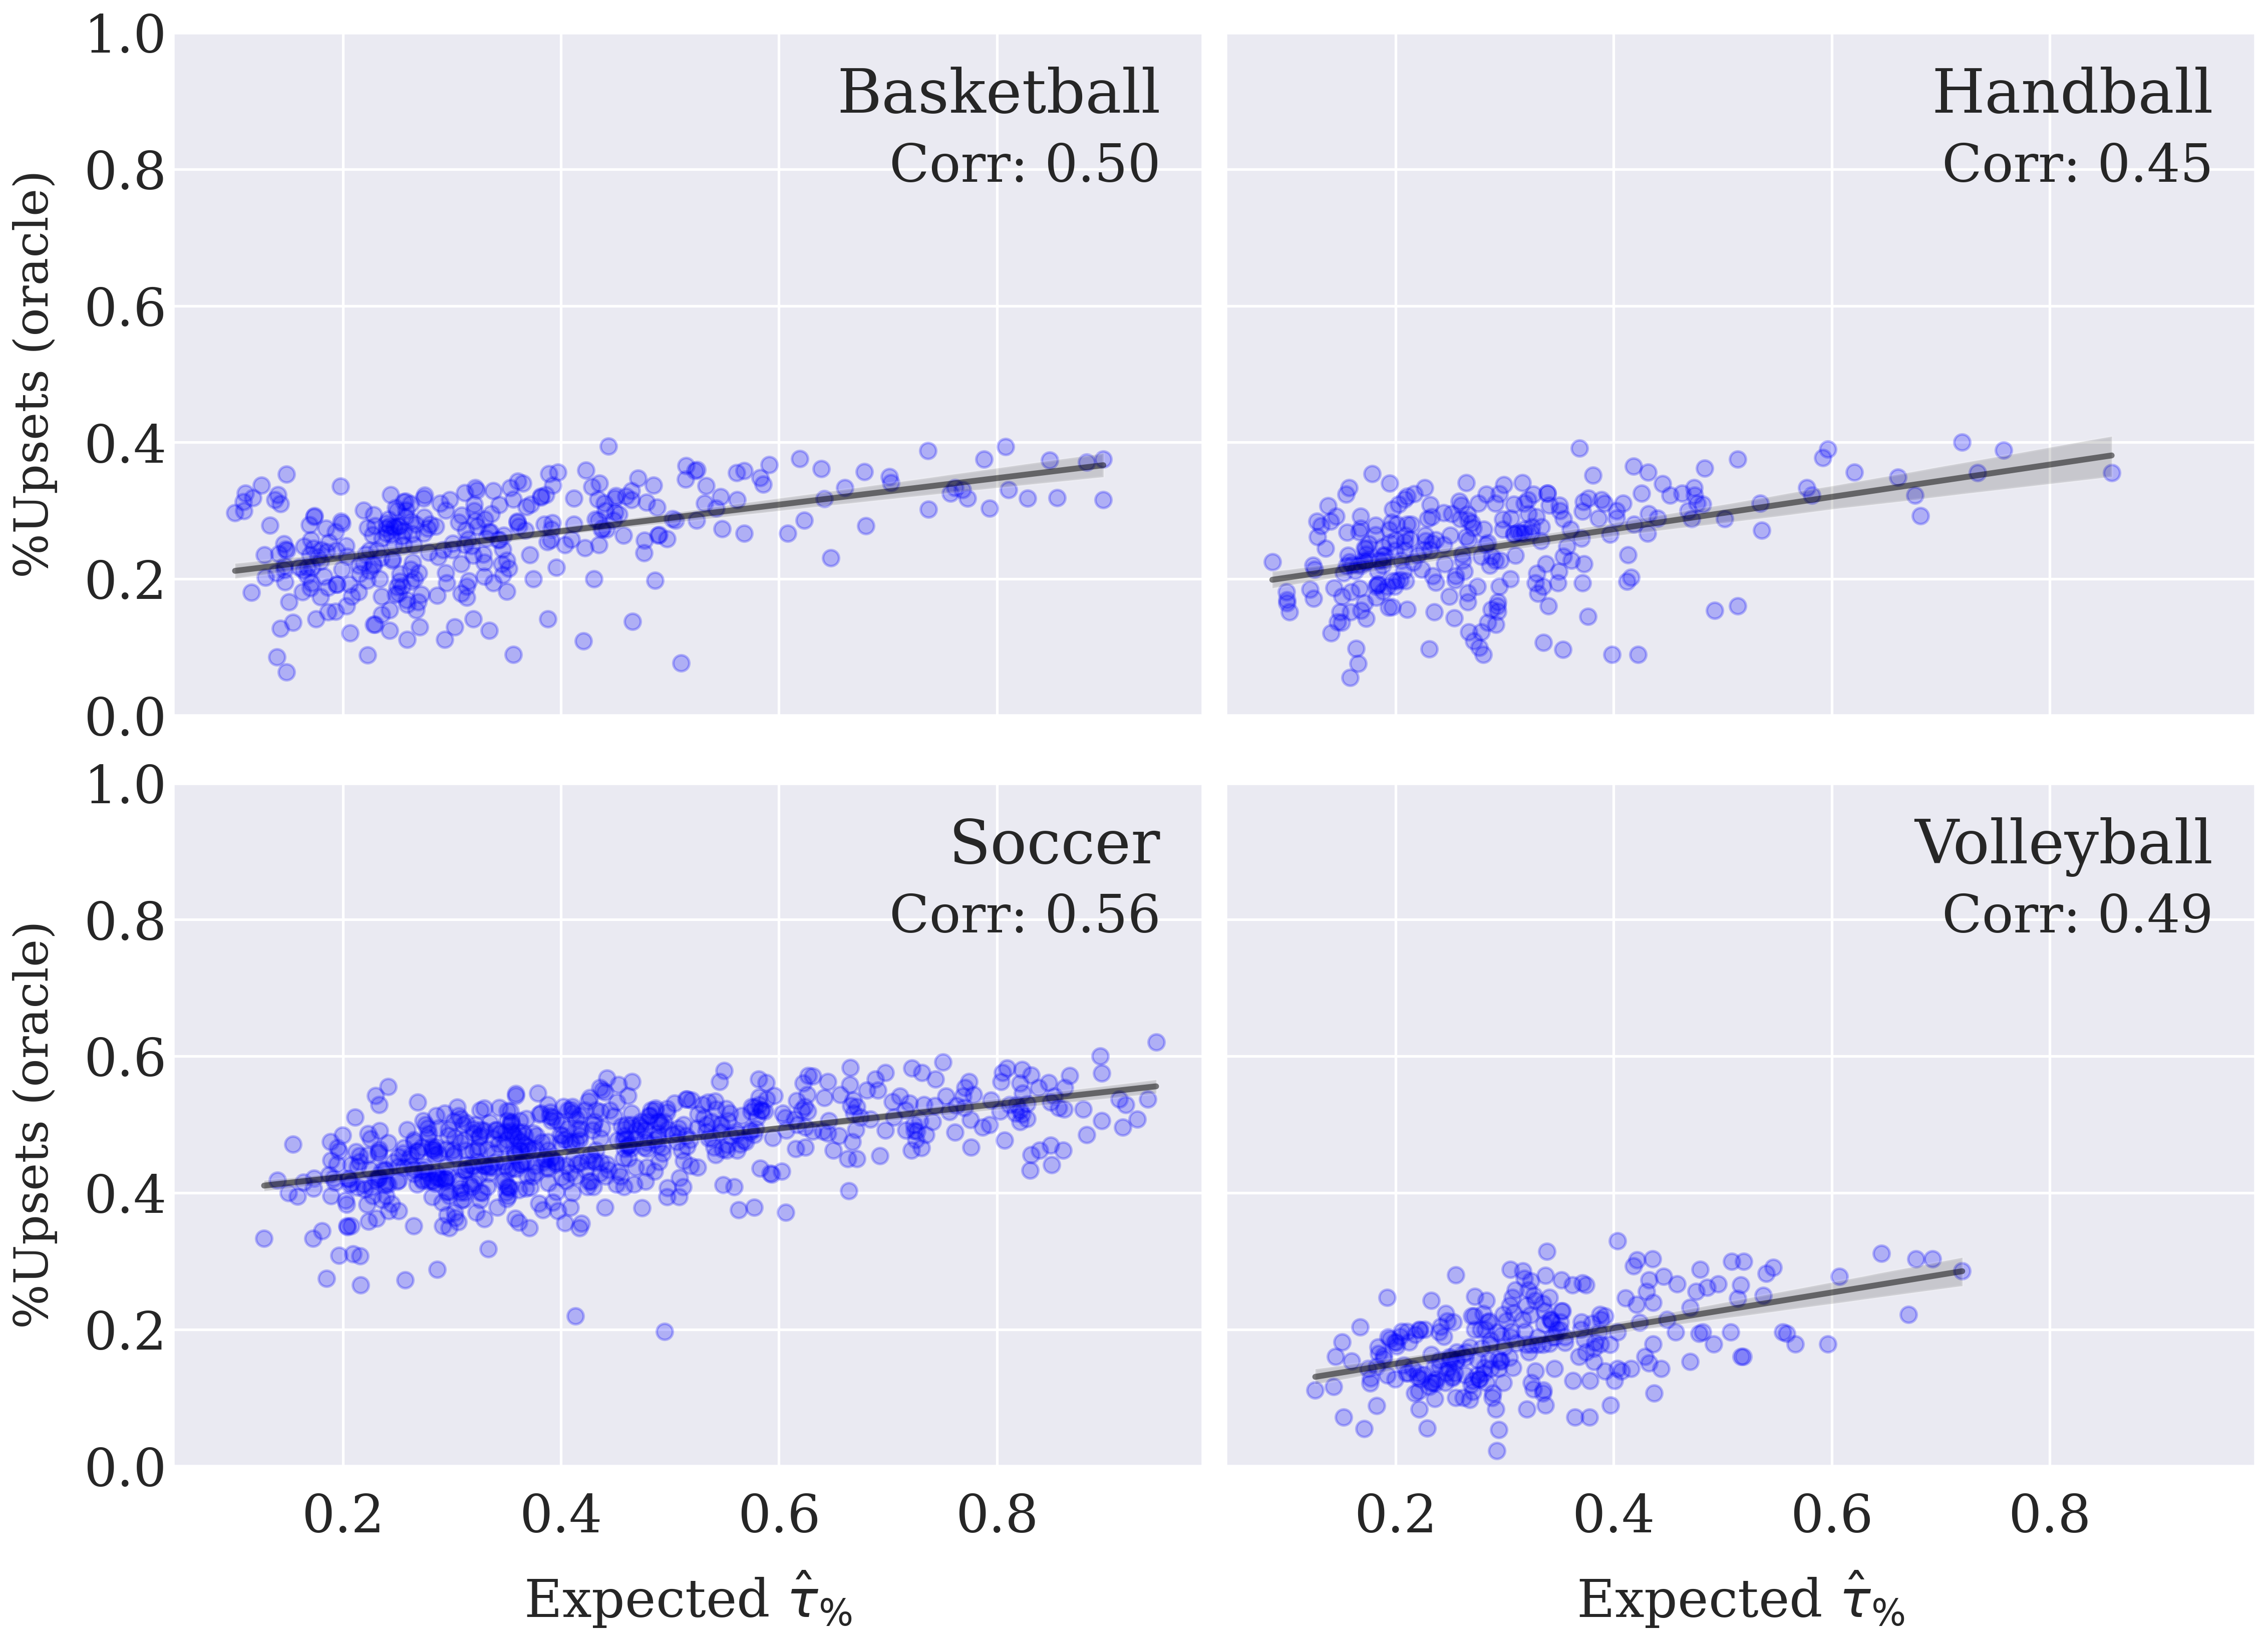

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(18, 13), sharex="all", sharey="all")


comp_scatter.plot_scatter_according_to_binned_intervals(
    fig, axs,
    sport_to_upset_df,
    PLOT_COLUMNS,
    linregress=True,
    x_equals_y_line=False,
    column_to_bin={"%upsets": "%upsets"},
    title_as_text_kwargs={"y": 0.95, "x": 0.95, "va": "top"},
    y_gt_x_percent_kwargs=None,
    pearson_corr_kwargs={"y": 0.84, "x": 0.95, "va": "top"},
)

first_ax = axs[0][0]
first_ax.set_ylim([0, 1])
axs[0][0].set_ylabel("%Upsets (oracle)", size=27)
axs[1][0].set_ylabel("%Upsets (oracle)", size=27)

plt.savefig(UPSETS_PATH / "oracle_upsets_comparison.pdf")

<h2> <b>Missing data</b> </h2>

In [12]:
MISSING_PATH = REVIEW_PATH / "missing/"
MISSING_PATH.mkdir(parents=True, exist_ok=True)

In [14]:
def run_missing_data(
    matches: Matches,
    fracs: list[float],
    seeds: list[float],
    sport: str,
    permute: bool = False,
) -> None:

    for frac, seed in zip(fracs, seeds):
        save_matches_path = MISSING_PATH / f"matches_{permute=}_{frac=}_{sport=}.csv"
        save_tp_path = MISSING_PATH / f"turning_point_{permute=}_{frac=}_{sport=}.csv"

        if save_matches_path.exists() and save_tp_path.exists():
            continue

        random.seed(seed)
        np.random.seed(seed)

        missing_data_matches = Matches(matches.df.groupby("id").sample(frac=frac, replace=False))
        missing_data_matches.df.to_csv(save_matches_path)

        if permute:
            missing_data_matches = permute_matches(missing_data_matches)

        turning_point = turning_point_from_matches(missing_data_matches)
        turning_point.df.to_csv(save_tp_path)

In [15]:
FRACS = [0.99, 0.95, 0.90]
SEEDS = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]

for seeds, sport in zip(SEEDS, ["volleyball"]):
    matches = key_to_sport_to_data["matches"][sport]
    run_missing_data(matches, FRACS, seeds, sport, permute=False)
    run_missing_data(matches, FRACS, seeds, sport, permute=True)

In [39]:
permute = True
sport = "volleyball"

TP_COLUMN = ("%turning point", "mean")

missing_tps = {
    "frac=1": key_to_sport_to_data["comparison_tp"]["volleyball"][TP_COLUMN]
}

for frac in FRACS:
    turning_point = PermutationTurningPoint(pd.read_csv(MISSING_PATH / f"turning_point_{permute=}_{frac=}_{sport=}.csv"))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        missing_tps[f"{frac=}"] = turning_point.statistical_measures([])[TP_COLUMN]

missing_tps = pd.concat(missing_tps, axis="columns").sort_index(axis="columns")
missing_tps.corr()

,frac=0.9,frac=0.95,frac=0.99,frac=1
frac=0.9,1.000000,0.866661,0.875276,0.897077
frac=0.95,0.866661,1.000000,0.908897,0.927390
frac=0.99,0.875276,0.908897,1.000000,0.975816
frac=1,0.897077,0.927390,0.975816,1.000000


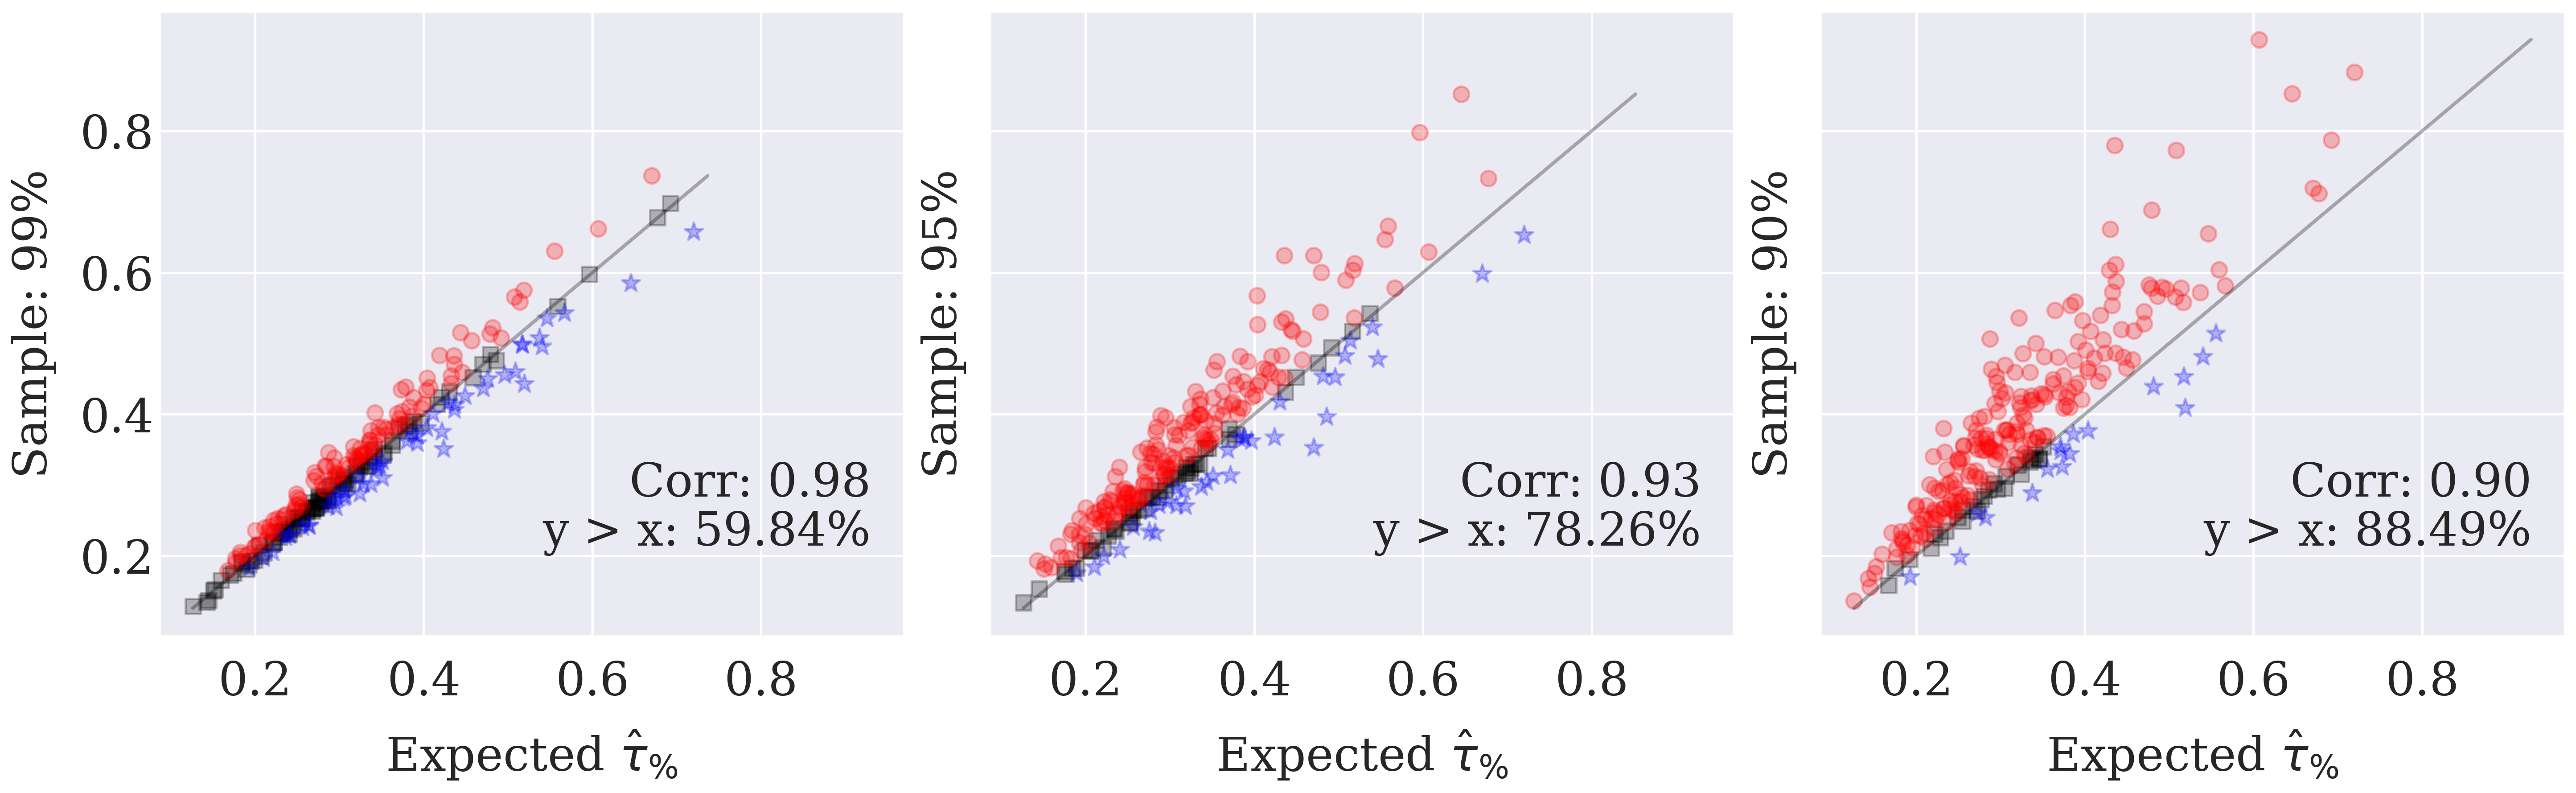

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(23, 7), sharex="all", sharey="all")

TP_COLUMN = "%turning point"
SCATTER_COLUMNS = {
    ("frac=1"): r"Expected $\hat\tau_\%$",
    ("frac=0.99"): r"Sample: 99%",
    ("frac=0.95"): r"Sample: 95%",
    ("frac=0.9"): r"Sample: 90%",
}

comp_scatter.plot_scatter_according_to_line_x_equals_y(
    fig, [axs],
    missing_tps, 
    SCATTER_COLUMNS,
    pearson_corr_kwargs={"y": 0.27, "x": 0.93},
    y_gt_x_percent_kwargs={"y": 0.2, "x": 0.93},
    title_as_text_kwargs=None,
)
plt.savefig(MISSING_PATH / "missing_data_plot.pdf")

<h2> <b>Effect of Upsets</b> </h2>

In [57]:
import tournament_simulations.schedules.round_robin as ts_rr
from tournament_simulations.schedules import convert_list_of_rounds_to_dataframe
import tournament_simulations.simulations as simul

In [66]:
from itertools import product
import pandas as pd

TEAM_TO_SKILL = {
    0: 1/9, 1: 1/9,
    2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1,
    8: 9, 9: 9,
}

def _calculate_probability(
    team_to_skill: dict[int, float],
    home: int,
    away: int
) -> dict[str, float]:
    home_win = team_to_skill[home] / (team_to_skill[home] + team_to_skill[away])
    return {"h": home_win, "a": 1 - home_win}

def get_team_to_prob(team_to_skill: dict[int, float]) -> dict[tuple[int, int]: dict[str, float]]:
    return {
        (home_team, away_team): _calculate_probability(team_to_skill, home_team, away_team)
        for home_team, away_team in product(team_to_skill.keys(), team_to_skill.keys())
    }

def bias_team_to_prob_towards_upsets(
    teams_to_prob: dict[tuple[int, int]: dict[str, float]],
    prob_worst_team_win: float
) -> dict[tuple[int, int]: dict[str, float]]:
    new_teams_to_prob = teams_to_prob.copy()

    for key in product([0, 1], [8, 9]):
        new_teams_to_prob[key] = {"h": prob_worst_team_win, "a": 1 - prob_worst_team_win}
        new_teams_to_prob[tuple(reversed(key))] = {"h": 1 - prob_worst_team_win, "a": prob_worst_team_win}

    return new_teams_to_prob

In [71]:
def simulate_tournament_prone_to_upsed(team_to_prob: dict[tuple[int, int]: dict[str, float]]) -> pd.DataFrame:

    drr = ts_rr.DoubleRoundRobin.from_num_teams(len(TEAM_TO_SKILL))
    schedule = drr.get_full_schedule(2)
    matches = Matches(convert_list_of_rounds_to_dataframe(schedule, "simulation"))

    simul_matches = simul.SimulateMatches(matches)
    return simul_matches.match_wide(
        num_iteration_simulation=(5, 20),
        match_to_probabilities=matches.df[["home", "away"]].agg(tuple, axis="columns").map(team_to_prob),
        func_after_simulation=lambda x: x
    )

def stack_simulation_results(results: pd.DataFrame) -> Matches:
    stacked_results = results.stack().rename("winner").reset_index(["home", "away"])

    old_id = stacked_results.index.get_level_values("id")
    simulation_number = stacked_results.index.get_level_values(2).str.removeprefix("s")
    new_id = "bradley_terry@" + old_id.astype(str) + "@" + simulation_number

    new_index = pd.MultiIndex.from_arrays([new_id.rename("id"), stacked_results.index.get_level_values("date number")])
    return Matches(stacked_results.set_index(new_index).sort_index())

In [96]:
def run_effect_of_upsets(
    prob_large_upset: list[float],
    num_simulations: int, 
    team_to_skill: dict[int, float] = TEAM_TO_SKILL,
) -> pd.DataFrame:
    team_to_prob = get_team_to_prob(team_to_skill)

    prob_to_tps = {}

    for prob in prob_large_upset:

        turning_logger.info(f"Starting {prob=}")
        
        simulations = []

        for simulation in range(num_simulations):
            turning_logger.info(f"Starting {simulation=}")

            biased_team_to_prob = bias_team_to_prob_towards_upsets(team_to_prob, prob)
            results = simulate_tournament_prone_to_upsed(biased_team_to_prob)

            stacked_results = stack_simulation_results(results)
            simulations.append(turning_point_from_matches(stacked_results).df.mean())

        prob_to_tps[prob] = pd.concat(simulations)

    return pd.concat(prob_to_tps, axis="columns").sort_index()


In [97]:
PROB_UPSET = [1/9 / (1/9 + 9), 0.05, 0.075, 0.1, 0.125]

random.seed(1)
np.random.seed(1)

effect_of_upsets = run_effect_of_upsets(PROB_UPSET, num_simulations=25)
effect_of_upsets

,0.012195,0.050000,0.075000,0.100000,0.125000
%turning point,0.135278,0.163889,0.191389,0.179444,0.194722
%turning point,0.193611,0.158611,0.193056,0.196944,0.167222
%turning point,0.164167,0.135556,0.142778,0.225000,0.204444
%turning point,0.188611,0.159444,0.176111,0.201667,0.185556
%turning point,0.190556,0.195833,0.180556,0.175556,0.190556
%turning point,0.153333,0.204722,0.161111,0.209167,0.181944
%turning point,0.138333,0.145833,0.163889,0.170556,0.178889
%turning point,0.166389,0.187500,0.191667,0.200833,0.174167
%turning point,0.161111,0.165000,0.145000,0.178611,0.204722
%turning point,0.131667,0.165278,0.186667,0.180556,0.193056


In [98]:
effect_of_upsets.loc["%turning point"].mean()

0.012195    0.162200
0.050000    0.176033
0.075000    0.176278
0.100000    0.187611
0.125000    0.191167
dtype: float64